In [403]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import math
import glob
import itertools

In [495]:
data = {
'Baseline': [],
'Peak': [],
'Latency': [],
'Difficulty': [],
'Accuracy': [],
'Reaction Time': []
}

for i in range(1,53):
    subject = pd.read_csv(f'Pupil Data\Pupil Data\subject_{i}_behave.csv')
    ind = subject.set_index('Time')
    behave = pd.read_csv(f'Behavioral Data\Behavioral Data\subject_{i}_behave.csv')
    
    start = behave['Time']
    end = behave['Time'] + behave['RT']
    
    for j in range(40):
        baseline = int(4*round(start[j]/4))
        if not math.isnan(end[j]):
            endline = int(4*round(end[j]/4))
        else:
            endline = int(4*round((start[j]+8000)/4))
        m = ind.loc[baseline:endline].sub(ind.loc[baseline])
        mx = max(m['Pupil Diameter'])
        data['Baseline'].append(ind.loc[baseline]['Pupil Diameter'])
        data['Peak'].append(mx)
        data['Latency'].append((np.where(m['Pupil Diameter'] == mx)[0][0])*4)
        data['Difficulty'].append(behave['Difficulty'][j])
        data['Accuracy'].append(behave['isCorrect'][j])
        if math.isnan(behave['RT'][j]):
            data['Reaction Time'].append(8000)
        else:
            data['Reaction Time'].append(behave['RT'][j])


In [496]:
import seaborn as sns
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error

In [497]:
df = pd.DataFrame(data)
df.head(10)

,Baseline,Peak,Latency,Difficulty,Accuracy,Reaction Time
0,4.767118,1.226772,3636,1,1,3635.104895
1,4.009070,1.809030,2852,2,1,2853.791475
2,4.877872,0.685657,1548,2,1,2182.772636
3,4.957144,0.735157,3180,2,0,3180.494785
4,4.221611,1.378095,3884,2,1,3880.589724
5,5.074790,0.402042,2996,2,0,2996.598721
6,4.577650,0.865967,2948,1,1,2948.635817
7,3.886891,1.188170,2592,2,1,2592.934370
8,4.936488,0.646439,2532,1,1,2531.351566
9,5.210759,0.498916,3216,2,1,3840.088606


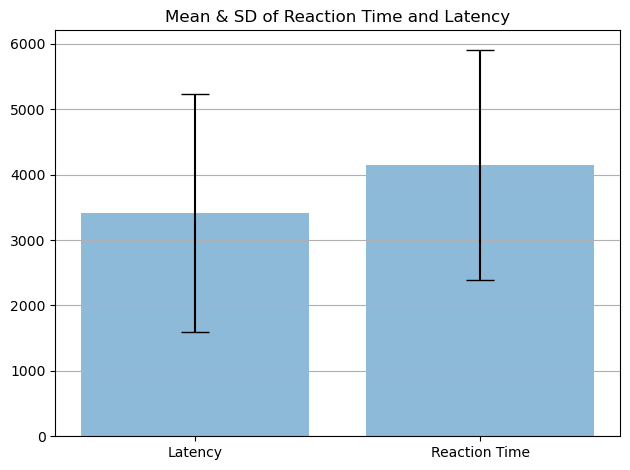

In [498]:
# Build the plot
rt_mean = np.mean(df['Reaction Time'])
lat_mean = np.mean(df['Latency'])

rt_std = np.std(df['Reaction Time'])
lat_std = np.std(df['Latency'])

labels = ['Latency', 'Reaction Time']
mean = [lat_mean, rt_mean]
error = [lat_std, rt_std]
x_pos = np.arange(len(labels))

fig, ax = plt.subplots()
ax.bar(x_pos, mean,
       yerr=error,
       align='center',
       alpha=0.5,
       ecolor='black',
       capsize=10)
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.set_title('Mean & SD of Reaction Time and Latency')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
plt.savefig('bar_plot_with_error_bars.png')
plt.show()

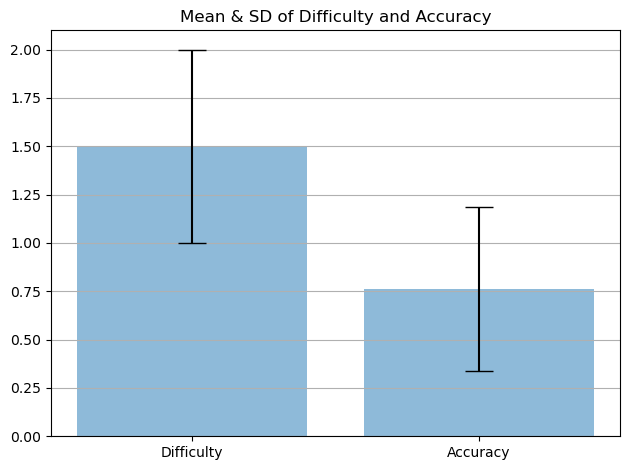

In [499]:
# Build the plot
diff_mean = np.mean(df['Difficulty'])
acc_mean = np.mean(df['Accuracy'])

diff_std = np.std(df['Difficulty'])
acc_std = np.std(df['Accuracy'])

labels = ['Difficulty', 'Accuracy']
mean = [diff_mean, acc_mean]
error = [diff_std, acc_std]
x_pos = np.arange(len(labels))

fig, ax = plt.subplots()
ax.bar(x_pos, mean,
       yerr=error,
       align='center',
       alpha=0.5,
       ecolor='black',
       capsize=10)
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.set_title('Mean & SD of Difficulty and Accuracy')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
plt.savefig('bar_plot_with_error_bars.png')
plt.show()

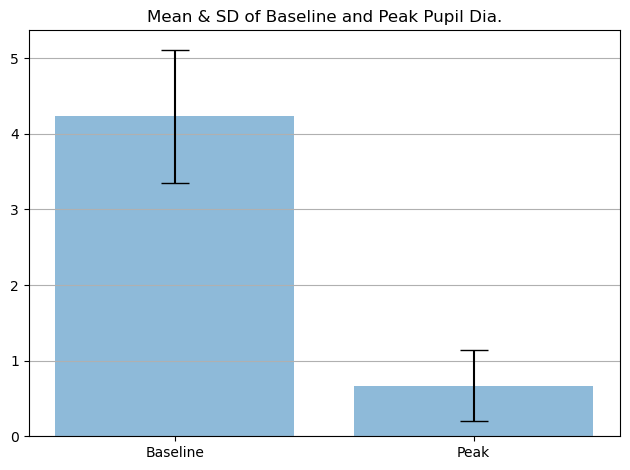

In [500]:
# Build the plot
diff_mean = np.mean(df['Baseline'])
acc_mean = np.mean(df['Peak'])

diff_std = np.std(df['Baseline'])
acc_std = np.std(df['Peak'])

labels = ['Baseline', 'Peak']
mean = [diff_mean, acc_mean]
error = [diff_std, acc_std]
x_pos = np.arange(len(labels))

fig, ax = plt.subplots()
ax.bar(x_pos, mean,
       yerr=error,
       align='center',
       alpha=0.5,
       ecolor='black',
       capsize=10)
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.set_title('Mean & SD of Baseline and Peak Pupil Dia.')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
plt.savefig('bar_plot_with_error_bars.png')
plt.show()

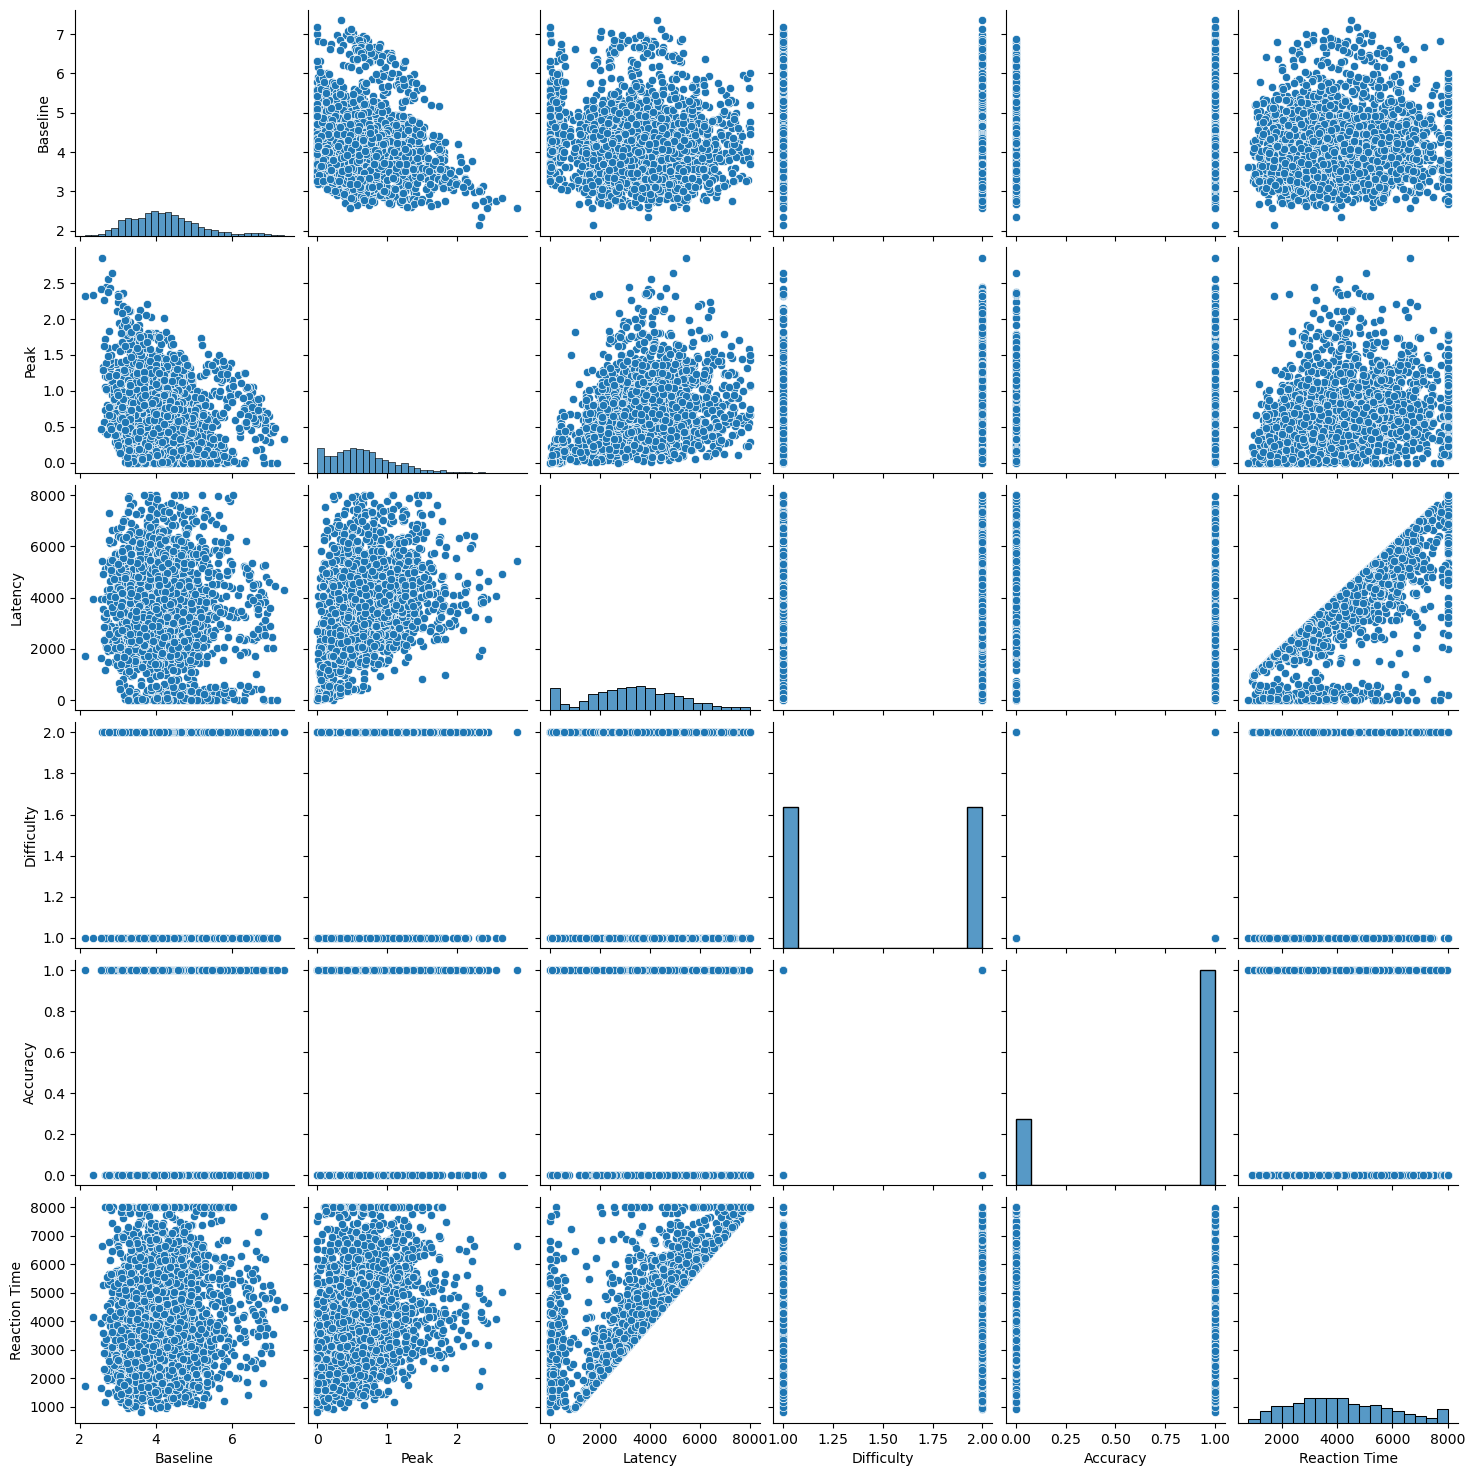

In [501]:
sns.pairplot(df)

# Accuracy Prediction

In [519]:
features = ['Baseline', 'Peak', 'Latency', 'Difficulty', 'Reaction Time']
X = df.loc[:, features]
y = df.loc[:, ['Accuracy']]
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42, train_size=0.75)

In [520]:
# Hyper tuning
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# define models and parameters
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l1','l2', 'elasticnet']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X, y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.787019 using {'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}
0.000000 (0.000000) with: {'C': 100, 'penalty': 'l1', 'solver': 'newton-cg'}
0.000000 (0.000000) with: {'C': 100, 'penalty': 'l1', 'solver': 'lbfgs'}
0.781731 (0.013689) with: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
0.782212 (0.013719) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.772436 (0.009722) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.771795 (0.008115) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.000000 (0.000000) with: {'C': 100, 'penalty': 'elasticnet', 'solver': 'newton-cg'}
0.000000 (0.000000) with: {'C': 100, 'penalty': 'elasticnet', 'solver': 'lbfgs'}
0.000000 (0.000000) with: {'C': 100, 'penalty': 'elasticnet', 'solver': 'liblinear'}
0.000000 (0.000000) with: {'C': 10, 'penalty': 'l1', 'solver': 'newton-cg'}
0.000000 (0.000000) with: {'C': 10, 'penalty': 'l1', 'solver': 'lbfgs'}
0.781731 (0.013519) with: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'

C:\Users\river\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
750 fits failed out of a total of 1350.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
150 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\river\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\river\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\river\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
Va

In [521]:
reg = LogisticRegression(C=1, penalty='l1', solver='liblinear')
reg.fit(X_train, y_train.values.ravel())
print("R^2 score = ", reg.score(X_test, y_test))

R^2 score =  0.7711538461538462


In [522]:
y_pred = reg.predict(X_test)
print('Accuracy: ',metrics.accuracy_score(y_test, y_pred))
print('Recall: ',metrics.recall_score(y_test, y_pred, zero_division=1))
print('Precision:',metrics.precision_score(y_test, y_pred, zero_division=1))
print('CL Report:',metrics.classification_report(y_test, y_pred, zero_division=1))

Accuracy:  0.7711538461538462
Recall:  0.9949367088607595
Precision: 0.7705882352941177
CL Report:               precision    recall  f1-score   support

           0       0.80      0.06      0.12       125
           1       0.77      0.99      0.87       395

    accuracy                           0.77       520
   macro avg       0.79      0.53      0.49       520
weighted avg       0.78      0.77      0.69       520



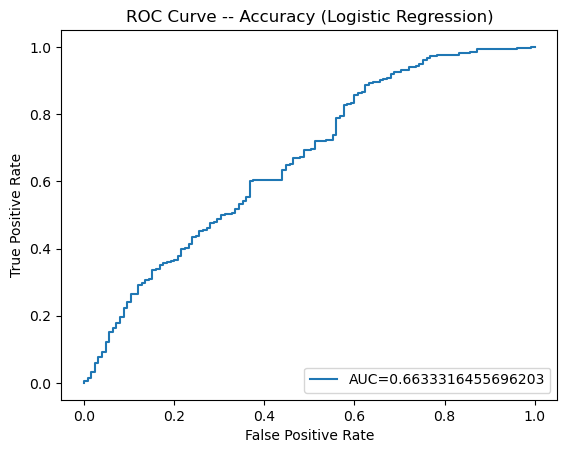

In [523]:
y_pred_proba = reg.predict_proba(X_test) [::,1]
false_positive_rate, true_positive_rate, _ = metrics.roc_curve(y_test, y_pred_proba, pos_label=1)
auc= metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(false_positive_rate, true_positive_rate,label="AUC="+str(auc))
plt.title('ROC Curve -- Accuracy (Logistic Regression)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

# Difficulty Prediction

In [524]:
features = ['Baseline', 'Peak', 'Latency', 'Accuracy', 'Reaction Time']
X = df.loc[:, features]
y = df.loc[:, ['Difficulty']]
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42, train_size=0.75)

In [525]:
# Hyper Tuning
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# define models and parameters
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l1','l2', 'elasticnet']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X, y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.612019 using {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}
0.000000 (0.000000) with: {'C': 100, 'penalty': 'l1', 'solver': 'newton-cg'}
0.000000 (0.000000) with: {'C': 100, 'penalty': 'l1', 'solver': 'lbfgs'}
0.605128 (0.030171) with: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
0.605128 (0.030577) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.602083 (0.030093) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.606891 (0.030449) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.000000 (0.000000) with: {'C': 100, 'penalty': 'elasticnet', 'solver': 'newton-cg'}
0.000000 (0.000000) with: {'C': 100, 'penalty': 'elasticnet', 'solver': 'lbfgs'}
0.000000 (0.000000) with: {'C': 100, 'penalty': 'elasticnet', 'solver': 'liblinear'}
0.000000 (0.000000) with: {'C': 10, 'penalty': 'l1', 'solver': 'newton-cg'}
0.000000 (0.000000) with: {'C': 10, 'penalty': 'l1', 'solver': 'lbfgs'}
0.605288 (0.030212) with: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'

C:\Users\river\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
750 fits failed out of a total of 1350.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
150 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\river\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\river\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\river\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
Va

In [526]:
reg = LogisticRegression(C=100, penalty='l2', solver='lbfgs')
reg.fit(X_train, y_train.values.ravel())
print("R^2 score = ", reg.score(X_test, y_test))

R^2 score =  0.6057692307692307


In [527]:
y_pred = reg.predict(X_test)
print('Accuracy: ',metrics.accuracy_score(y_test, y_pred))
print('Recall: ',metrics.recall_score(y_test, y_pred, zero_division=1))
print('Precision:',metrics.precision_score(y_test, y_pred, zero_division=1))
print('CL Report:',metrics.classification_report(y_test, y_pred, zero_division=1))

Accuracy:  0.6057692307692307
Recall:  0.634453781512605
Precision: 0.5613382899628253
CL Report:               precision    recall  f1-score   support

           1       0.56      0.63      0.60       238
           2       0.65      0.58      0.62       282

    accuracy                           0.61       520
   macro avg       0.61      0.61      0.61       520
weighted avg       0.61      0.61      0.61       520



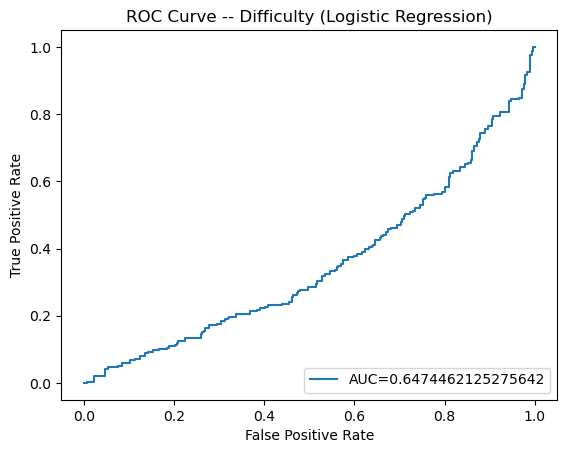

In [528]:
y_pred_proba = reg.predict_proba(X_test) [::,1]
false_positive_rate, true_positive_rate, _ = metrics.roc_curve(y_test, y_pred_proba, pos_label=1)
auc= metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(false_positive_rate, true_positive_rate,label="AUC="+str(auc))
plt.title('ROC Curve -- Difficulty (Logistic Regression)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

# Reaction Time Prediction

In [512]:
features = ['Baseline', 'Peak', 'Latency', 'Accuracy', 'Difficulty']
X = df.loc[:, features]
y = df.loc[:, ['Reaction Time']]
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42, train_size=0.75)

In [513]:
reg = LinearRegression()
reg.fit(X_train, y_train)
print("R^2 score = ", reg.score(X_test, y_test))

R^2 score =  0.6282849991272073


In [514]:
from sklearn.linear_model import Ridge
import numpy as np
from sklearn.model_selection import GridSearchCV


parameters = {'alpha':[1, 10]}

# define the model/ estimator
model = Ridge()

# define the grid search
Ridge_reg= GridSearchCV(model, parameters, scoring='neg_mean_squared_error',cv=5)

#fit the grid search
Ridge_reg.fit(X,y)

# best estimator
print(Ridge_reg.best_estimator_)

# best model
best_model = Ridge_reg.best_estimator_
best_model.fit(X,y)

reg = Ridge(alpha=10)
reg.fit(X_train, y_train)
print("R^2 score = ", reg.score(X_test, y_test))

Ridge(alpha=10)
R^2 score =  0.6281473384506834


In [515]:
max_depth_range = list(range(1, 25))
use_depth = 0
max_score = float('-inf')
# List to store the average RMSE for each value of max_depth:
r2_list = []
for depth in max_depth_range:
    reg = DecisionTreeRegressor(max_depth = depth,
                            random_state = 0)
    reg.fit(X_train, y_train)   
    
    score = reg.score(X_test, y_test)
    r2_list.append(score)
    if max_score < score:
        use_depth = depth
        max_score = score

In [516]:
reg = DecisionTreeRegressor(max_depth = use_depth, random_state = 0)
reg.fit(X_train, y_train.values.ravel())
print("R^2 score = ", reg.score(X_test, y_test))

R^2 score =  0.6939523505356646


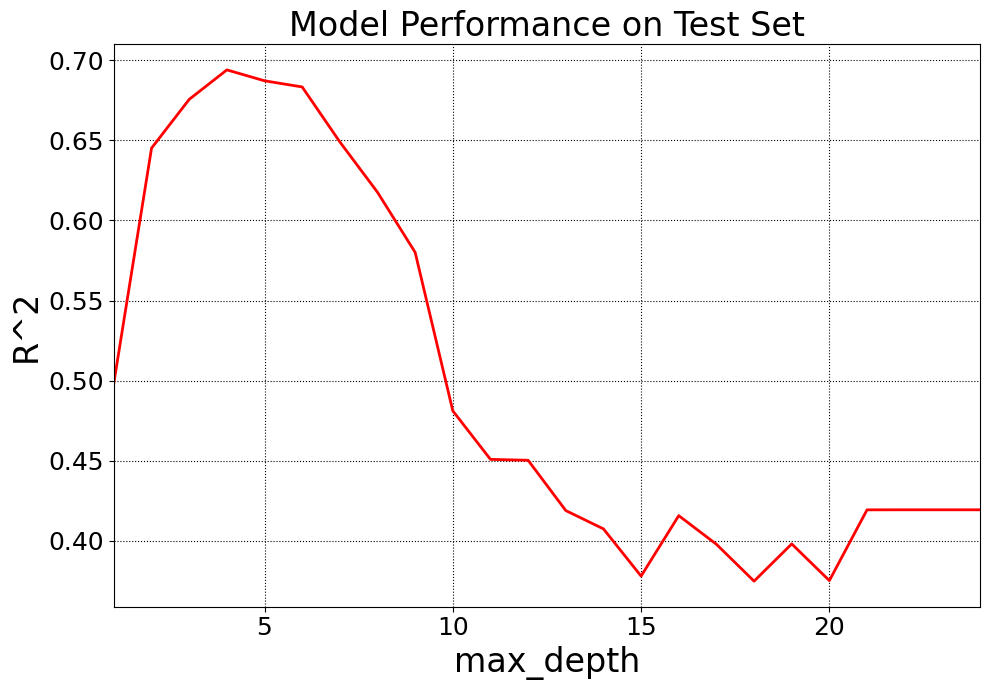

In [529]:
fig, ax = plt.subplots(nrows = 1, ncols = 1,
                       figsize = (10,7),
                       facecolor = 'white');
ax.plot(max_depth_range,
       r2_list,
       lw=2,
       color='r')
ax.set_xlim([1, max(max_depth_range)])
ax.grid(True,
       axis = 'both',
       zorder = 0,
       linestyle = ':',
       color = 'k')
ax.tick_params(labelsize = 18)
ax.set_xlabel('max_depth', fontsize = 24)
ax.set_ylabel('R^2', fontsize = 24)
ax.set_title('Model Performance on Test Set', fontsize = 24)
fig.tight_layout()

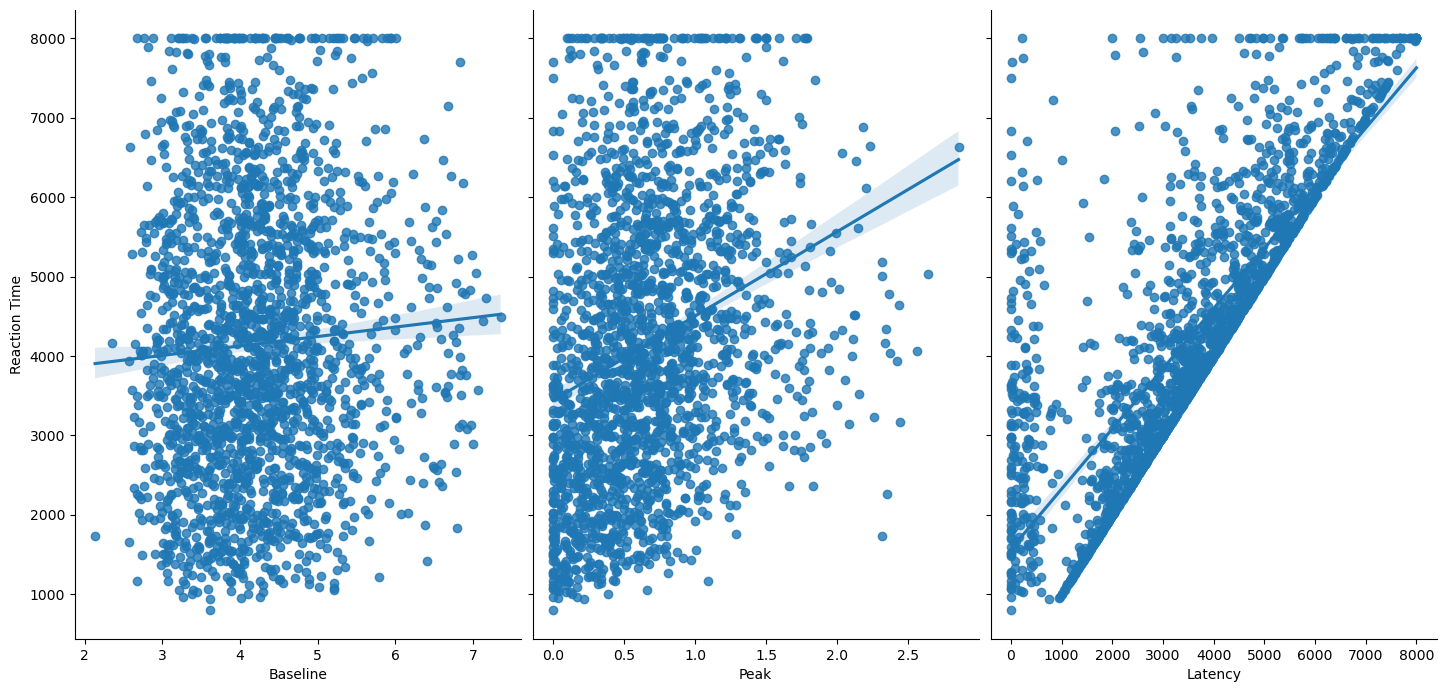

In [518]:
sns.pairplot(df, x_vars=['Baseline', 'Peak', 'Latency'], y_vars='Reaction Time', height=7, aspect=0.7, kind='reg')